<a href="https://colab.research.google.com/github/tkalra11/PyTorch_FCC/blob/master/02_pytorch_classification_run.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Neural Network classification with PyTorch

**Classification** - Problem of predicting wether something is one thing or another.

## 1. Making classification data ready

In [1]:
import sklearn

In [2]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Creating circles

X,y = make_circles(n_samples,
                   noise = 0.03,
                   random_state = 42)

In [3]:
len(X),len(y)

(1000, 1000)

In [4]:
print(f"First 5 samples of X : \n {X[:5]}")
print(f"First 5 samples of y : \n {y[:5]}")

First 5 samples of X : 
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y : 
 [1 1 1 1 0]


In [5]:
# Creating a data frame for the data

import pandas as pd

circles = pd.DataFrame({"X1" : X[:,0],
                        "X2" : X[:,1],
                        "labels" : y[:]})

circles.head()

,X1,X2,labels
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


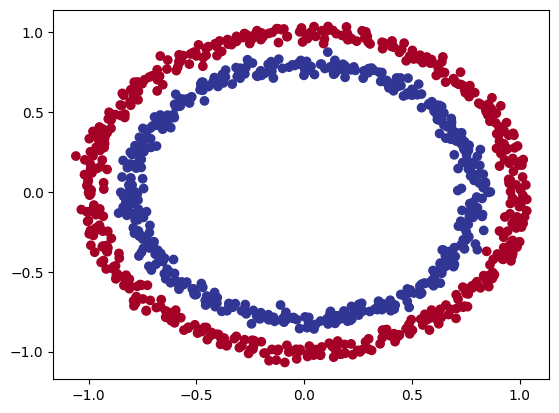

In [6]:
# Visualising the data

import matplotlib.pyplot as plt

plt.scatter(x = X[: , 0] ,
            y = X[: , 1],
            c = y,
            cmap = plt.cm.RdYlBu)

### 1.1 Checking the input and output shapes

In [7]:
X.shape,y.shape

((1000, 2), (1000,))

In [8]:
X_sample = X[0]
y_sample = y[0]

print(f"X sample : \n{X_sample}\ny sample :\n{y_sample}")
print(f"X sample shape : {X_sample.shape}")
print(f"y sample shape : {y_sample.shape}")

X sample : 
[0.75424625 0.23148074]
y sample :
1
X sample shape : (2,)
y sample shape : ()


### 1.2 Converting data to tensors and splitting the data



In [9]:
import torch
torch.__version__

'2.0.1+cu118'

In [10]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [11]:
X[:5],y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [12]:
from sklearn.model_selection import train_test_split

X_train  , X_test , y_train , y_test = train_test_split( X , 
                                                        y ,
                                                        test_size = 0.2 , 
                                                        random_state = 42)

In [13]:
len(X_train) , len(X_test)

(800, 200)

## 2. Building a model

steps : 
1. Set up device agnostic code
2. model using nn.Modules
3. Loss funcation and optimizer
4. Training and testing loop

In [14]:
import torch
from torch import nn

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [16]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features = 2,
                                 out_features = 5)
        self.layer_2 = nn.Linear(in_features = 5,
                                 out_features = 1)
    
    def forward(self, x:torch.Tensor) -> torch.Tensor :
        return self.layer_2(self.layer_1(x))

In [17]:
model_0 = CircleModelV1().to(device)

In [18]:
model_0

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [19]:
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.0247,  0.1853],
                      [-0.3376,  0.5515],
                      [-0.0914,  0.5368],
                      [ 0.3357,  0.3077],
                      [-0.4285, -0.5998]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.3582, -0.2424, -0.2533, -0.6689, -0.2801], device='cuda:0')),
             ('layer_2.weight',
              tensor([[-0.2359, -0.2540, -0.0559, -0.0715, -0.1004]], device='cuda:0')),
             ('layer_2.bias', tensor([-0.1345], device='cuda:0'))])

In [20]:
model_1 = nn.Sequential(
    nn.Linear(in_features = 2, out_features = 5),
    nn.Linear(in_features = 5, out_features = 1)
).to(device)

In [21]:
model_1

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [22]:
# Making predictions
with torch.inference_mode():
    untrained_preds = model_1(X_test.to(device))

print(torch.round(untrained_preds[:10]))

tensor([[-0.],
        [-0.],
        [0.],
        [-0.],
        [0.],
        [0.],
        [-0.],
        [-0.],
        [0.],
        [-0.]], device='cuda:0')


In [23]:
# Loss function and optimizer

loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params = model_1.parameters(),
                            lr = 0.1)

In [24]:
# Calculating accuracy 
def accuracy_fn(y_true , y_pred):
    correct = torch.eq(y_true , y_pred).sum().item()
    acc = (correct / len(y_pred))*100
    return acc

## 3. Training the model

In [25]:
model_1.eval()

with torch.inference_mode():
    y_pred_labels = torch.round(torch.sigmoid(model_1(X_test.to(device))[:5]))

In [26]:
model_1.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.3200, -0.5339],
                      [-0.5657, -0.6929],
                      [-0.0307, -0.0911],
                      [ 0.5805, -0.4203],
                      [ 0.3975,  0.0109]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.2215, -0.1288, -0.5585, -0.6882, -0.4895], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.0759,  0.2598,  0.3483,  0.1099, -0.0206]], device='cuda:0')),
             ('1.bias', tensor([0.2596], device='cuda:0'))])

In [27]:
torch.cuda.manual_seed(42)

epochs = 1000

X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    
    model_1.train()

    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits,y_train)
    acc = accuracy_fn(y_true = y_train,
                      y_pred = y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        test_loss = loss_fn(test_logits , y_test)

        test_acc = accuracy_fn(y_true = y_test,
                               y_pred = test_pred)
    
    if epoch % 100 == 0:
        print(f"Epoch : {epoch}\t| Loss : {loss: .5f}\t| Test Loss : {test_loss: .5f}\t| Accuracy : {acc: .3f}\t| Test Accuracy : {test_acc: .3f}")

Epoch : 0	| Loss :  0.70035	| Test Loss :  0.69126	| Accuracy :  48.875	| Test Accuracy :  54.500
Epoch : 100	| Loss :  0.69362	| Test Loss :  0.69220	| Accuracy :  49.375	| Test Accuracy :  53.000
Epoch : 200	| Loss :  0.69307	| Test Loss :  0.69380	| Accuracy :  51.375	| Test Accuracy :  47.500
Epoch : 300	| Loss :  0.69300	| Test Loss :  0.69437	| Accuracy :  51.125	| Test Accuracy :  47.000
Epoch : 400	| Loss :  0.69299	| Test Loss :  0.69456	| Accuracy :  51.375	| Test Accuracy :  46.500
Epoch : 500	| Loss :  0.69298	| Test Loss :  0.69463	| Accuracy :  51.625	| Test Accuracy :  46.000
Epoch : 600	| Loss :  0.69298	| Test Loss :  0.69465	| Accuracy :  50.875	| Test Accuracy :  45.500
Epoch : 700	| Loss :  0.69298	| Test Loss :  0.69467	| Accuracy :  51.375	| Test Accuracy :  45.500
Epoch : 800	| Loss :  0.69298	| Test Loss :  0.69467	| Accuracy :  51.250	| Test Accuracy :  45.500
Epoch : 900	| Loss :  0.69298	| Test Loss :  0.69468	| Accuracy :  51.250	| Test Accuracy :  46.000


## 4. Plotting the models

In [28]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists")
else:
    request = requests.get("https://github.com/tkalra11/PyTorch_FCC/blob/master/helper_functions.py?raw=true")
    with open("helper_functions.py" , "wb") as f:
        f.write(request.content)

In [29]:
from helper_functions import plot_predictions , plot_decision_boundary

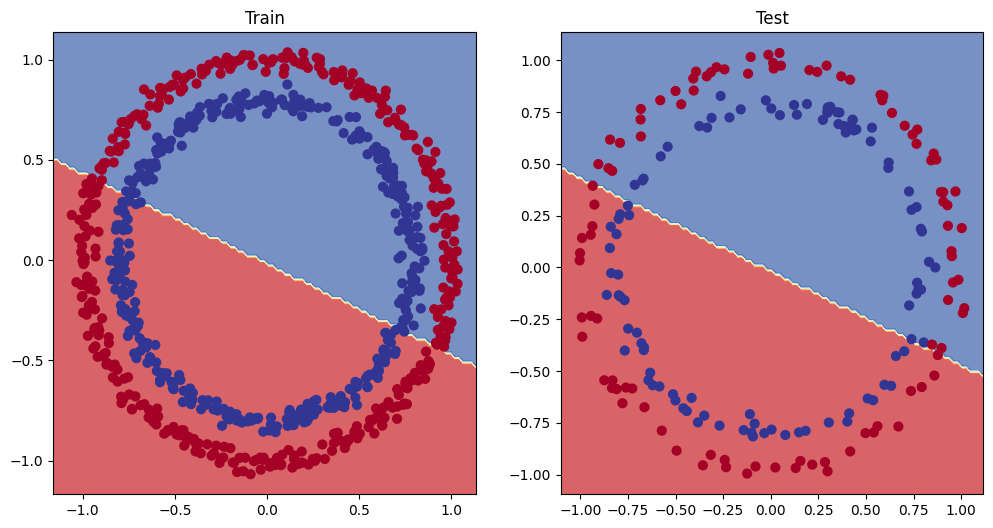

In [30]:
# Ploting the decision boundary of the model

plt.figure(figsize = (12 , 6))
plt.subplot( 1 , 2 , 1 )
plt.title("Train")
plot_decision_boundary(model_1 , X_train , y_train)

plt.subplot(1 , 2 , 2 )
plt.title("Test")
plot_decision_boundary(model_1 , X_test , y_test)

## 5. Improving a model (model's perspective)

Options : 

* Add more layers
* Add more hidden units
* Fit for longer
* Changing the activation functions
* Change the learning rate
* Change the loss function

In [31]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features =  2 , out_features = 10)
        self.layer_2 = nn.Linear(in_features =  10 , out_features = 10)
        self.layer_3 = nn.Linear(in_features =  10 , out_features = 1)
    
    def forward(self , x:torch.Tensor) -> torch.Tensor :
        return self.layer_3(self.layer_2(self.layer_1(x)))

In [32]:
model_2 = CircleModelV2().to(device)

model_2

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [33]:
# Loss Function
loss_fn = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = torch.optim.SGD(params = model_2.parameters(),
                            lr = 0.1)

In [34]:
# Training and testing loop

torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train , y_train = X_train.to(device),y_train.to(device)
X_test , y_test = X_test.to(device) , y_test.to(device)

for epoch in range(epochs):
    
    model_2.train()

    y_logits = model_2(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    loss = loss_fn(y_logits , y_train)
    acc = accuracy_fn(y_true = y_train,y_pred = y_pred)
    
    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_2.eval()
    with torch.inference_mode():
        test_logits = model_2(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits , y_test)
        test_acc = accuracy_fn(y_true = y_test , y_pred = test_pred)
        
    if epoch%100 == 0:
        print(f"Epoch : {epoch}\t| Loss : {loss: .5f}\t| Test Loss : {test_loss: .5f}\t| Accuracy : {acc: .3f}\t| Test Accuracy : {test_acc: .3f}")

Epoch : 0	| Loss :  0.70545	| Test Loss :  0.70481	| Accuracy :  50.000	| Test Accuracy :  50.000
Epoch : 100	| Loss :  0.69301	| Test Loss :  0.69404	| Accuracy :  51.500	| Test Accuracy :  46.000
Epoch : 200	| Loss :  0.69298	| Test Loss :  0.69446	| Accuracy :  51.375	| Test Accuracy :  45.500
Epoch : 300	| Loss :  0.69298	| Test Loss :  0.69460	| Accuracy :  51.500	| Test Accuracy :  45.500
Epoch : 400	| Loss :  0.69298	| Test Loss :  0.69465	| Accuracy :  51.250	| Test Accuracy :  45.000
Epoch : 500	| Loss :  0.69298	| Test Loss :  0.69467	| Accuracy :  51.125	| Test Accuracy :  45.500
Epoch : 600	| Loss :  0.69298	| Test Loss :  0.69468	| Accuracy :  51.125	| Test Accuracy :  46.000
Epoch : 700	| Loss :  0.69298	| Test Loss :  0.69468	| Accuracy :  51.000	| Test Accuracy :  46.000
Epoch : 800	| Loss :  0.69298	| Test Loss :  0.69468	| Accuracy :  51.000	| Test Accuracy :  46.000
Epoch : 900	| Loss :  0.69298	| Test Loss :  0.69468	| Accuracy :  51.000	| Test Accuracy :  46.000


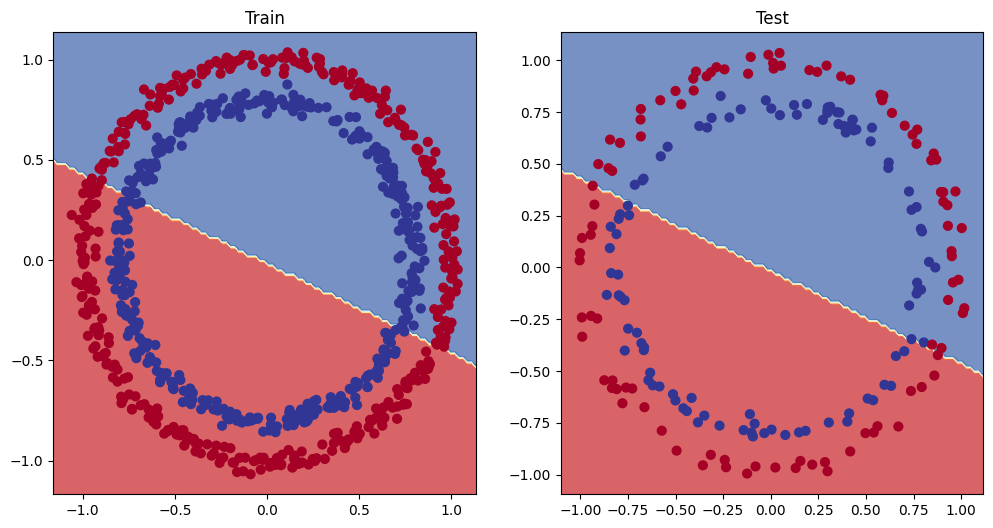

In [35]:
plt.figure(figsize = (12 , 6))
plt.subplot( 1 , 2 , 1 )
plt.title("Train")
plot_decision_boundary(model_2 , X_train , y_train)

plt.subplot(1 , 2 , 2 )
plt.title("Test")
plot_decision_boundary(model_2 , X_test , y_test)

## 6. Introducing Non-Linearity

In [36]:
import torch
from torch import nn
import matplotlib.pyplot as plt

In [37]:
from sklearn.datasets import make_circles

In [38]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

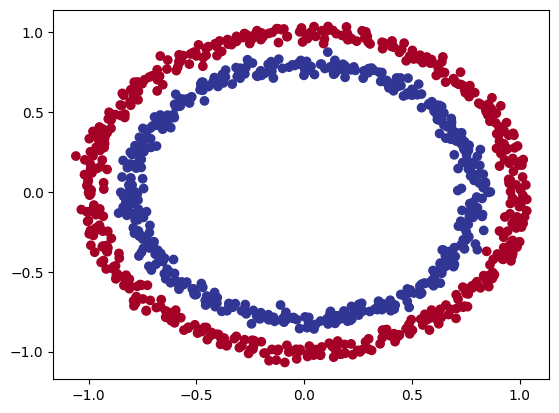

In [39]:
n_samples = 1000

X , y =make_circles(n_samples,
                    noise = 0.03 , 
                    random_state = 42)
 
plt.scatter(X [: , 0] , X[: , 1] , c = y ,cmap = plt.cm.RdYlBu);

In [40]:
from sklearn.model_selection import train_test_split

In [41]:
# Data to tensors then split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train , X_test , y_train , y_test = train_test_split(X ,
                                                       y ,
                                                       test_size = 0.2 , 
                                                       random_state = 42 )

print(X_train[:5] , y_train[:5])

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        [-0.9666, -0.2256],
        [-0.1666,  0.7994]]) tensor([1., 0., 0., 0., 1.])


In [42]:
class CircleModelV3(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear( in_features = 2 , out_features = 10)
        self.layer_2 = nn.Linear( in_features = 10 , out_features = 10)
        self.layer_3 = nn.Linear( in_features = 10 , out_features = 1)
        self.relu = nn.ReLU()

    def forward(self , x:torch.Tensor) -> torch.Tensor :
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

In [43]:
model_3 = CircleModelV3().to(device)
model_3

CircleModelV3(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [44]:
model_3.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984], device='cuda:0')),
             ('layer_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.122

In [45]:
# Loss Function
loss_fn = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = torch.optim.SGD(params = model_3.parameters(),
                            lr = 0.1)

In [46]:
# Training and testing loop

torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 2000

X_train , y_train = X_train.to(device),y_train.to(device)
X_test , y_test = X_test.to(device) , y_test.to(device)

for epoch in range(epochs):
    
    model_3.train()

    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    loss = loss_fn(y_logits , y_train)
    acc = accuracy_fn(y_true = y_train,y_pred = y_pred)
    
    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits , y_test)
        test_acc = accuracy_fn(y_true = y_test , y_pred = test_pred)
        
    if epoch%100 == 0:
        print(f"Epoch : {epoch}\t| Loss : {loss: .5f}\t| Test Loss : {test_loss: .5f}\t| Accuracy : {acc: .3f}\t| Test Accuracy : {test_acc: .3f}")

Epoch : 0	| Loss :  0.69295	| Test Loss :  0.69319	| Accuracy :  50.000	| Test Accuracy :  50.000
Epoch : 100	| Loss :  0.69115	| Test Loss :  0.69102	| Accuracy :  52.875	| Test Accuracy :  52.500
Epoch : 200	| Loss :  0.68977	| Test Loss :  0.68940	| Accuracy :  53.375	| Test Accuracy :  55.000
Epoch : 300	| Loss :  0.68795	| Test Loss :  0.68723	| Accuracy :  53.000	| Test Accuracy :  56.000
Epoch : 400	| Loss :  0.68517	| Test Loss :  0.68411	| Accuracy :  52.750	| Test Accuracy :  56.500
Epoch : 500	| Loss :  0.68102	| Test Loss :  0.67941	| Accuracy :  52.750	| Test Accuracy :  56.500
Epoch : 600	| Loss :  0.67515	| Test Loss :  0.67285	| Accuracy :  54.500	| Test Accuracy :  56.000
Epoch : 700	| Loss :  0.66659	| Test Loss :  0.66322	| Accuracy :  58.375	| Test Accuracy :  59.000
Epoch : 800	| Loss :  0.65160	| Test Loss :  0.64757	| Accuracy :  64.000	| Test Accuracy :  67.500
Epoch : 900	| Loss :  0.62362	| Test Loss :  0.62145	| Accuracy :  74.000	| Test Accuracy :  79.000
Ep

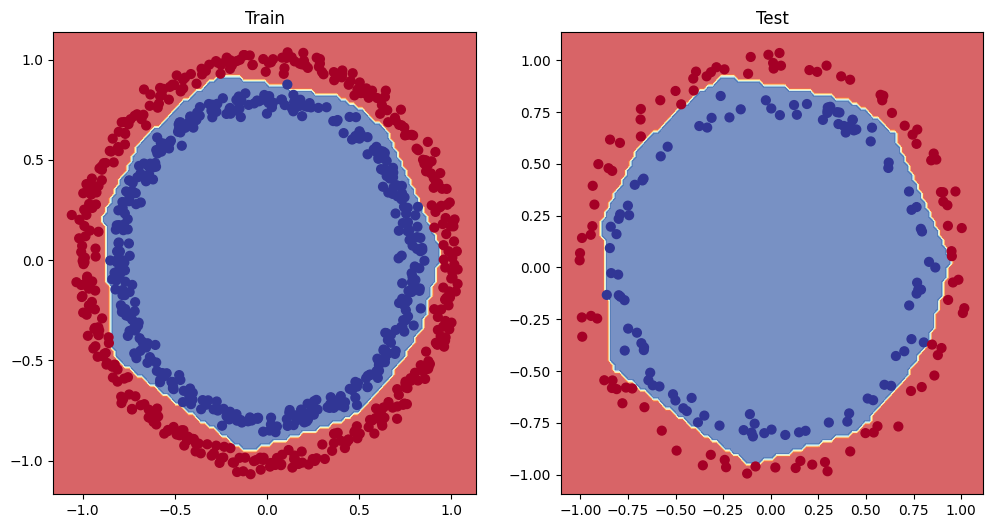

In [47]:
plt.figure(figsize = (12 , 6))
plt.subplot( 1 , 2 , 1 )
plt.title("Train")
plot_decision_boundary(model_3 , X_train , y_train)

plt.subplot(1 , 2 , 2 )
plt.title("Test")
plot_decision_boundary(model_3 , X_test , y_test)

## 7. Putting it all togethor with multiclass classification

In [87]:
# Dependencies

import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

### 7.1 Creating the dataset

In [88]:
# Setting up hyperparameters

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

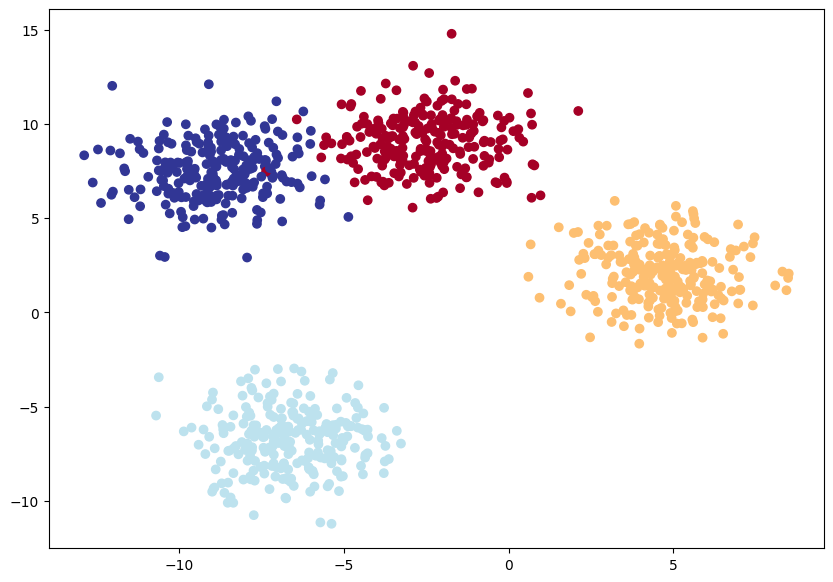

In [89]:
# Create the data
X_blob , y_blob = make_blobs(n_samples = 1000,
                             n_features = NUM_FEATURES , 
                             centers = NUM_CLASSES , 
                             cluster_std = 1.5 , 
                             random_state = RANDOM_SEED)

# Data to tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

#Split the data
X_train , X_test , y_train , y_test = train_test_split(X_blob,
                                                       y_blob,
                                                       test_size = 0.2 ,
                                                       random_state = RANDOM_SEED)

# Plot the data
plt.figure(figsize = (10,7))
plt.scatter(X_blob[: , 0] , X_blob[: , 1] , c=y_blob , cmap = plt.cm.RdYlBu);

### 7.2 Creating a multiclass classification model

In [90]:
# Create device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [91]:
# Create model class
class BlobModelV0(nn.Module):
    def __init__(self , input_features , output_features , hidden_units = 8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features = input_features , out_features = hidden_units),
            # nn.ReLU(),            
            nn.Linear(in_features = hidden_units , out_features = hidden_units),
            # nn.ReLU(),
            nn.Linear(in_features = hidden_units , out_features = output_features)
        )

    def forward(self , x):
        return self.linear_layer_stack(x)

In [92]:
blob_model = BlobModelV0(input_features = 2 , output_features  =4 , hidden_units = 8).to(device)
blob_model

BlobModelV0(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 7.3 Loss Function and optimizer

In [93]:
# Loss  function
loss_fn = nn.CrossEntropyLoss()

# Optimizer 
optimizer = torch.optim.SGD(params = blob_model.parameters() , 
                         lr = 0.1)

### 7.4 Training and testing loop

In [94]:
# Untrained model predictions

X_train , y_train = X_train.to(device) , y_train.to(device)
X_test , y_test = X_test.to(device) , y_test.to(device)

blob_model.eval()
with torch.inference_mode():
    untrained_logits  = blob_model(X_test)
    untrained_pred_probs = torch.softmax( untrained_logits , dim = 1)

untrained_pred_probs[:10] , y_test[:10] , torch.argmax(untrained_pred_probs , dim = 1)[:10]

(tensor([[0.1872, 0.2918, 0.1495, 0.3715],
         [0.2824, 0.0149, 0.2881, 0.4147],
         [0.3380, 0.0778, 0.4854, 0.0989],
         [0.2118, 0.3246, 0.1889, 0.2748],
         [0.1945, 0.0598, 0.1506, 0.5951],
         [0.2788, 0.0088, 0.2893, 0.4232],
         [0.3246, 0.1261, 0.4545, 0.0948],
         [0.2229, 0.0443, 0.1867, 0.5461],
         [0.3447, 0.0368, 0.5269, 0.0917],
         [0.2145, 0.0510, 0.1752, 0.5593]], device='cuda:0'),
 tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0'),
 tensor([3, 3, 2, 1, 3, 3, 2, 3, 2, 3], device='cuda:0'))

In [95]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

X_train , y_train = X_train.to(device) , y_train.to(device)
X_test , y_test = X_test.to(device) , y_test.to(device)

epochs = 100
for epoch in range(epochs):

    blob_model.train()

    y_logits = blob_model(X_train)
    y_pred_probs = torch.softmax(y_logits , dim = 1)
    y_preds = torch.argmax(y_pred_probs , dim = 1)

    loss = loss_fn(y_logits , y_train)
    acc = accuracy_fn(y_true = y_train , 
                      y_pred = y_preds)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    blob_model.eval()
    with torch.inference_mode():
        test_logits = blob_model(X_test)
        test_preds = torch.softmax(test_logits , dim = 1).argmax( dim = 1)

        test_loss = loss_fn(test_logits , y_test)
        test_acc = accuracy_fn(y_true = y_test,
                          y_pred = test_preds)
        
    if epoch%10 == 0:
        print(f"Epoch : {epoch}\t| Loss : {loss: .5f}\t| Test Loss : {test_loss: .5f}\t| Accuracy : {acc: .3f}\t| Test Accuracy : {test_acc: .3f}")

Epoch : 0	| Loss :  1.04324	| Test Loss :  0.57861	| Accuracy :  65.500	| Test Accuracy :  95.500
Epoch : 10	| Loss :  0.14398	| Test Loss :  0.13037	| Accuracy :  99.125	| Test Accuracy :  99.000
Epoch : 20	| Loss :  0.08062	| Test Loss :  0.07216	| Accuracy :  99.125	| Test Accuracy :  99.500
Epoch : 30	| Loss :  0.05924	| Test Loss :  0.05133	| Accuracy :  99.125	| Test Accuracy :  99.500
Epoch : 40	| Loss :  0.04892	| Test Loss :  0.04098	| Accuracy :  99.000	| Test Accuracy :  99.500
Epoch : 50	| Loss :  0.04295	| Test Loss :  0.03486	| Accuracy :  99.000	| Test Accuracy :  99.500
Epoch : 60	| Loss :  0.03910	| Test Loss :  0.03083	| Accuracy :  99.000	| Test Accuracy :  99.500
Epoch : 70	| Loss :  0.03643	| Test Loss :  0.02799	| Accuracy :  99.000	| Test Accuracy :  99.500
Epoch : 80	| Loss :  0.03448	| Test Loss :  0.02587	| Accuracy :  99.000	| Test Accuracy :  99.500
Epoch : 90	| Loss :  0.03300	| Test Loss :  0.02423	| Accuracy :  99.125	| Test Accuracy :  99.500


### 7.5 Making and evaluating predictions 

In [96]:
blob_model.eval()
with torch.inference_mode():
    y_logits = blob_model(X_test)
    y_pred_probs = torch.softmax(y_logits , dim = 1)
    y_preds = torch.argmax(y_pred_probs ,dim = 1)

y_preds[:10] , y_test[:10]

(tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0'),
 tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0'))

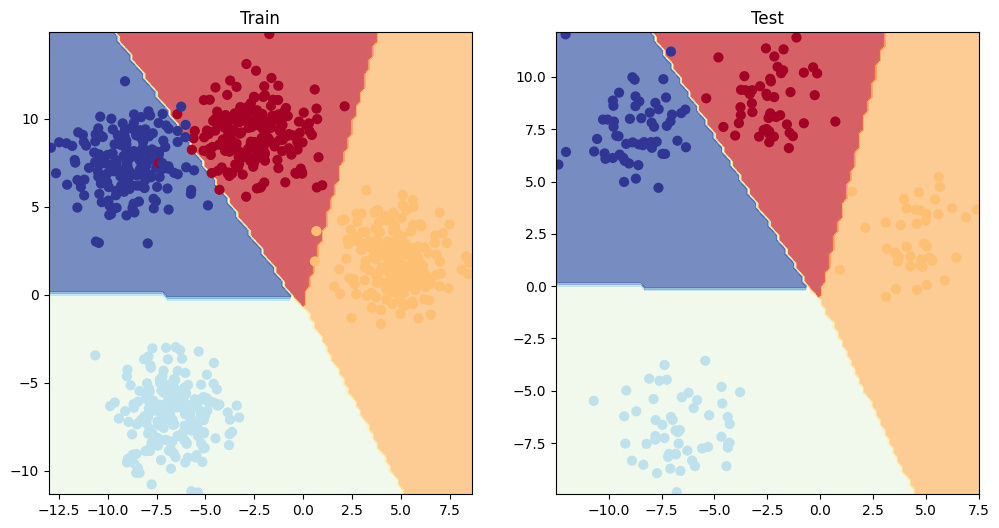

In [97]:
# Plotting the predictions

plt.figure(figsize = (12 , 6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(blob_model , X_train , y_train)

plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(blob_model , X_test , y_test)

## 8. Classification Metrics

* Accuracy - how many right , not for imbalanced classes
* Precision - high &uarr; less false positive
* Recall - high &uarr; less false negative 
* F1 Score 
* Confusion Matrix 
* Clasification report 

**Note:**There is a precision - recall tradeoff